In [4]:
# Referenced from https://github.com/DL4mHealth/COMET/blob/main/data_preprocessing/PTB/PTB_preprocessing.ipynb
import os
import wfdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datautils import normalize, resample, R_Peaks, trial2sample, sample2trial

In [5]:
# specify the unziped data path and diagnostics file path
data_path = '../training2017'
label_path = '../training2017/REFERENCE-v3.csv'

In [6]:
labels = pd.read_csv(label_path, header=None)

In [7]:
labels

,0,1
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A
...,...,...
8523,A08524,N
8524,A08525,O
8525,A08526,N
8526,A08527,N


In [8]:
label_dict = {
    'N': 0,
    'A': 1,
    'O': 2,
    '~': 3
}
labels.replace(label_dict, inplace=True)
labels.columns = ['Recording', 'Label']
labels

/var/folders/s2/gg0gc5y53z979n2bskjqp6kc0000gn/T/ipykernel_4145/3603717577.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels.replace(label_dict, inplace=True)


,Recording,Label
0,A00001,0
1,A00002,0
2,A00003,0
3,A00004,1
4,A00005,1
...,...,...
8523,A08524,0
8524,A08525,2
8525,A08526,0
8526,A08527,0


In [9]:
records_name = labels['Recording'].values
len(records_name)

8528

In [19]:
# get median R-Peak intervals for all trials, drop trials that contains nan or all zero
med_intervals = []
nan_trial = []
allzero_trial = []
abnormal_trial = []
for record in records_name:
    path =  os.path.join(data_path, record)
    ecg_data = wfdb.rdsamp(record_name=path)[0]
    if np.all(ecg_data == 0):
        allzero_trial.append(record)
        print(f'All zero: {record}')
        continue
    if np.any(np.isnan(ecg_data)):
        nan_trial.append(record)
        print(f'Nan: {record}')
        continue
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=300, freq2=250, kind='linear'))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    try:
        _, med, _ = R_Peaks(trial_norm)
        med_intervals.append(med.to_list())
    except IndexError:
        abnormal_trial.append(record)
        print(f'IndexError: {record}')

print(len(nan_trial), len(allzero_trial), len(abnormal_trial))
new_records_name = [r for r in records_name if r not in nan_trial + allzero_trial + abnormal_trial]
print(len(new_records_name))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

0 0 0
8528


,0,1,2,3,4,5,6,7,8,9,...,8518,8519,8520,8521,8522,8523,8524,8525,8526,8527
0,189.5,247.0,186.0,231.0,113.0,262.0,239.0,221.0,158.0,230.0,...,198.0,255.0,287.0,207.0,218.0,216.0,177.5,208.0,153.0,235.0


In [20]:
# 6805 records suitable for analysis
med_all = df_med_intervals.median()
print(med_all[med_all <= 300].shape)
print(med_all[med_all <= 300].max())
max_duration = 300

(8335,)
300.0


In [21]:
# remove records that have median interval length greater than max duration
med_intervals = []
abnormal_trial = []
med_nan_trial = []
for record in new_records_name:
    path = os.path.join(data_path, record)
    ecg_data = wfdb.rdsamp(record_name=path)[0]
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=300, freq2=250, kind='linear'))
    trial = np.array(trial).T
    trial_norm = normalize(trial)
    try:
        _, med, _ = R_Peaks(trial_norm)
        if med.median() <= max_duration:
            if np.any(np.isnan(med)):
                med_nan_trial.append(record)
                print(f'Med Nan: {record}')
                continue
            med_intervals.append(med.to_list())
        else:
            abnormal_trial.append(record)
            print(f'Outlider: {record}')
    except IndexError:
        abnormal_trial.append(record)
        print(f'IndexError: {record}')
        
print(len(abnormal_trial), len(med_nan_trial))
final_records_name = [r for r in new_records_name if r not in abnormal_trial + med_nan_trial]
print(len(final_records_name))
df_med_intervals = pd.DataFrame(med_intervals).T
df_med_intervals

Outlider: A00074
Outlider: A00078
Outlider: A00112


/Users/xiaoyudembp/miniforge3/envs/pytorch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Outlider: A00229
Outlider: A00237
Outlider: A00243
Outlider: A00251
Outlider: A00255
Outlider: A00291
Outlider: A00298
Outlider: A00324
Outlider: A00329
Outlider: A00340
Outlider: A00344
Outlider: A00345
Outlider: A00394
Outlider: A00516
Outlider: A00529
Outlider: A00533
Outlider: A00549
Outlider: A00561


/Users/xiaoyudembp/miniforge3/envs/pytorch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/xiaoyudembp/miniforge3/envs/pytorch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Outlider: A00593
Outlider: A00598
Outlider: A00603
Outlider: A00638
Outlider: A00697
Outlider: A00811
Outlider: A00872
Outlider: A00876
Outlider: A00889
Outlider: A00923
Outlider: A00957
Outlider: A00975
Outlider: A00993
Outlider: A01027
Outlider: A01073
Outlider: A01081
Outlider: A01115
Outlider: A01154
Outlider: A01175
Outlider: A01211
Outlider: A01310
Outlider: A01429
Outlider: A01458
Outlider: A01498
Outlider: A01581
Outlider: A01583
Outlider: A01602
Outlider: A01635
Outlider: A01643
Outlider: A01668
Outlider: A01672
Outlider: A01690
Outlider: A01709
Outlider: A01716


/Users/xiaoyudembp/miniforge3/envs/pytorch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Outlider: A01726
Outlider: A01880
Outlider: A01902
Outlider: A01903
Outlider: A01907
Outlider: A01924
Outlider: A02002
Outlider: A02090
Outlider: A02098
Outlider: A02177
Outlider: A02183
Outlider: A02229
Outlider: A02286
Outlider: A02303
Outlider: A02405
Outlider: A02630
Outlider: A02632
Outlider: A02668
Outlider: A02680
Outlider: A02684
Outlider: A02706
Outlider: A02709
Outlider: A02712
Outlider: A02725
Outlider: A02748
Outlider: A02798
Outlider: A02818
Outlider: A02974
Outlider: A03005
Outlider: A03095
Outlider: A03137
Outlider: A03278
Outlider: A03354
Outlider: A03373
Outlider: A03424
Outlider: A03461
Outlider: A03463
Outlider: A03499
Outlider: A03546
Outlider: A03619
Outlider: A03633
Outlider: A03643
Outlider: A03653
Outlider: A03692
Outlider: A03696
Outlider: A03701
Outlider: A03723
Outlider: A03737
Outlider: A03802
Outlider: A03820
Outlider: A03831
Outlider: A03851
Outlider: A03914
Outlider: A03917
Outlider: A03924
Outlider: A03994
Outlider: A04167
Outlider: A04173
Outlider: A041

/Users/xiaoyudembp/miniforge3/envs/pytorch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Outlider: A05300
Outlider: A05310
Outlider: A05352
Outlider: A05462
Outlider: A05492


/Users/xiaoyudembp/miniforge3/envs/pytorch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Outlider: A05556
Outlider: A05778
Outlider: A05780
Outlider: A05792
Outlider: A05818
Outlider: A05819
Outlider: A05925
Outlider: A06073
Outlider: A06191
Outlider: A06217
Outlider: A06226
Outlider: A06266
Outlider: A06335
Outlider: A06367
Outlider: A06416
Outlider: A06614
Outlider: A06647
Outlider: A06694
Outlider: A06718
Outlider: A06760
Outlider: A06808
Outlider: A06834
Outlider: A06890
Outlider: A07005
Outlider: A07049
Outlider: A07064
Outlider: A07156
Outlider: A07166
Outlider: A07308
Outlider: A07388
Outlider: A07542
Outlider: A07686
Outlider: A07689
Outlider: A07713
Outlider: A07785
Outlider: A07802
Outlider: A07840
Outlider: A07920
Outlider: A07978
Outlider: A08118
Outlider: A08148
Outlider: A08163
Outlider: A08301
Outlider: A08303
Outlider: A08312
Outlider: A08329
Outlider: A08365
Outlider: A08432
Outlider: A08516
193 0
8335


,0,1,2,3,4,5,6,7,8,9,...,8325,8326,8327,8328,8329,8330,8331,8332,8333,8334
0,189.5,247.0,186.0,231.0,113.0,262.0,239.0,221.0,158.0,230.0,...,198.0,255.0,287.0,207.0,218.0,216.0,177.5,208.0,153.0,235.0


In [22]:
# main
feature_path = '../dataset/cinc2017/feature'
if not os.path.exists(feature_path):
    os.makedirs(feature_path)
    
dict_label = {}
sub_id = 1
for record in final_records_name:
    label = labels[labels['Recording']==record]['Label'].values[0]
    if label == 3:
        continue
    dict_label[sub_id] = label
    ecg_data = wfdb.rdsamp(record_name=os.path.join(data_path, record))[0]
    trial = []
    for ch in range(ecg_data.shape[1]):
        trial.append(resample(ecg_data[:, ch], freq1=300, freq2=250, kind='linear'))
    trial = np.array(trial).T
    trial_norm = normalize(trial)

    samples = trial2sample(trial_norm, max_duration=300) # segment and pad

    segmentations = sample2trial(samples, size=6) # regroup
    
    if segmentations != list():
        segmentations = np.array(segmentations)
        print(segmentations.shape)
        np.save(os.path.join(feature_path, f'feature_{sub_id:05d}'), segmentations)
        sub_id += 1    
    else:
        print(f'The subject is None after preprocessing: {record}')  

(6, 1800, 1)
(5, 1800, 1)
(12, 1800, 1)
(5, 1800, 1)
(18, 1800, 1)
(4, 1800, 1)
(5, 1800, 1)
(11, 1800, 1)
(7, 1800, 1)
(11, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(7, 1800, 1)
(2, 1800, 1)
(4, 1800, 1)
(6, 1800, 1)
(10, 1800, 1)
(4, 1800, 1)
(7, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(5, 1800, 1)
(4, 1800, 1)
(7, 1800, 1)
(10, 1800, 1)
(8, 1800, 1)
(10, 1800, 1)
(7, 1800, 1)
(5, 1800, 1)
(5, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(14, 1800, 1)
(4, 1800, 1)
(3, 1800, 1)
(6, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(5, 1800, 1)
(7, 1800, 1)
(7, 1800, 1)
(5, 1800, 1)
(5, 1800, 1)
(5, 1800, 1)
(9, 1800, 1)
(4, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(6, 1800, 1)
(4, 1800, 1)
(14, 1800, 1)
(10, 1800, 1)
(10, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(9, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(5, 1800, 1)
(6, 1800, 1)
(12, 1800, 1)
(4, 1800, 1)
(6, 1800, 1)
(7, 1800, 1)
(5, 1800, 1)
(6, 1800, 1)
(8, 1800, 1)
(6, 1800, 1)
(5, 1800, 1)
(5, 1800, 1)
(7, 1800, 1)
(12, 1800, 1)

In [23]:
len(dict_label)

8059

In [24]:
label_path = '../dataset/cinc2017/label'
if not os.path.exists(label_path):
    os.makedirs(label_path)

df_label = pd.DataFrame([dict_label]).T
df_label = df_label.reset_index().astype('int64')
labels = df_label[[0, 'index']].values
np.save(os.path.join(label_path, 'label'), labels)

In [25]:
# test
sig = np.load('../dataset/cinc2017/feature/feature_01000.npy')
sig

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], shape=(7, 1800, 1))

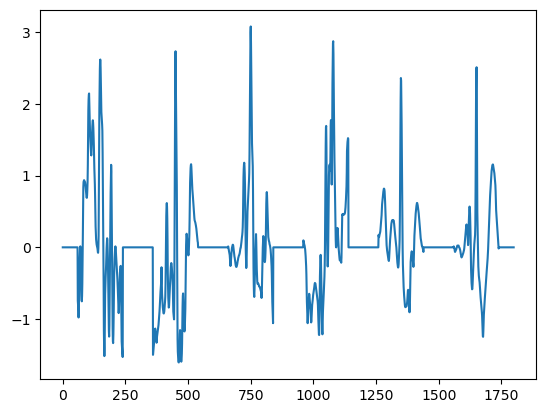

In [26]:
plt.plot(sig[0])

In [29]:
np.load('../dataset/cinc2017/label/label.npy')

array([[   0,    1],
       [   0,    2],
       [   0,    3],
       ...,
       [   0, 8057],
       [   0, 8058],
       [   0, 8059]], shape=(8059, 2))